In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# feature importance
import rfpimp
import sklearn

# xgboost
import xgboost

# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, validation_curve

# CART
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [4]:
pd.set_option("display.max_rows", 300)  # specifies number of rows to show
pd.options.display.float_format = (
    "{:40,.4f}".format
)  # specifies default number format to 4 decimal places
plt.style.use("ggplot")  # specifies that graphs should use ggplot styling
%matplotlib inline

In [5]:
# check the library version before we start
print("xgboost version:{}".format(xgboost.__version__))
print("sklearn version:{}".format(sklearn.__version__))

xgboost version:2.1.1
sklearn version:1.5.2


Data loading and exploration

In [6]:
bike_rental = pd.read_csv(
    "https://raw.githubusercontent.com/huanfachen/Spatial_Data_Science/main/Dataset/daily_count_bike_rental.csv"
)
# drop the year variable as it is not useful
bike_rental = bike_rental.drop(["yr"], axis=1)

In [7]:
bike_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cnt              731 non-null    int64  
 1   season           731 non-null    object 
 2   mnth             731 non-null    object 
 3   holiday          731 non-null    object 
 4   weekday          731 non-null    object 
 5   workingday       731 non-null    object 
 6   weathersit       731 non-null    object 
 7   temp             731 non-null    float64
 8   hum              731 non-null    float64
 9   windspeed        731 non-null    float64
 10  days_since_2011  731 non-null    int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 62.9+ KB


In [8]:
bike_rental.head()

,cnt,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,days_since_2011
0,985,SPRING,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.1758,80.5833,10.7499,0
1,801,SPRING,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.0835,69.6087,16.6521,1
2,1349,SPRING,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.2291,43.7273,16.6367,2
3,1562,SPRING,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.4000,59.0435,10.7398,3
4,1600,SPRING,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.6670,43.6957,12.5223,4


In [9]:
# Converting categorical variables
bike_rental_numeric = pd.get_dummies(bike_rental)

In [10]:
bike_rental_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cnt                         731 non-null    int64  
 1   temp                        731 non-null    float64
 2   hum                         731 non-null    float64
 3   windspeed                   731 non-null    float64
 4   days_since_2011             731 non-null    int64  
 5   season_FALL                 731 non-null    bool   
 6   season_SPRING               731 non-null    bool   
 7   season_SUMMER               731 non-null    bool   
 8   season_WINTER               731 non-null    bool   
 9   mnth_APR                    731 non-null    bool   
 10  mnth_AUG                    731 non-null    bool   
 11  mnth_DEZ                    731 non-null    bool   
 12  mnth_FEB                    731 non-null    bool   
 13  mnth_JAN                    731 non

In [11]:
bike_rental_final = bike_rental_numeric.drop(
    [
        "season_SPRING",
        "mnth_JAN",
        "holiday_NO HOLIDAY",
        "weekday_MON",
        "workingday_WORKING DAY",
        "weathersit_GOOD",
    ],
    axis=1,
)

# double check the result
bike_rental_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cnt                         731 non-null    int64  
 1   temp                        731 non-null    float64
 2   hum                         731 non-null    float64
 3   windspeed                   731 non-null    float64
 4   days_since_2011             731 non-null    int64  
 5   season_FALL                 731 non-null    bool   
 6   season_SUMMER               731 non-null    bool   
 7   season_WINTER               731 non-null    bool   
 8   mnth_APR                    731 non-null    bool   
 9   mnth_AUG                    731 non-null    bool   
 10  mnth_DEZ                    731 non-null    bool   
 11  mnth_FEB                    731 non-null    bool   
 12  mnth_JUL                    731 non-null    bool   
 13  mnth_JUN                    731 non

In [12]:
# Spliting data into random train and test subsets
random_state_split = 100
train_x, test_x, train_y, test_y = train_test_split(
    bike_rental_final.drop(["cnt"], axis=1),
    bike_rental_final.cnt,
    random_state=random_state_split,
)

In [13]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical. The index indicates which rows from the original data.

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(548, 28)
(548,)
(183, 28)
(183,)
True
True


Building a CART

In [42]:
# a CART using default settings
cart_default = DecisionTreeRegressor(random_state=0)
cart_default.fit(train_x, train_y)
# print the tree depth
print("Tree depth: {}".format(cart_default.get_depth()))

Tree depth: 25


In [43]:
# values of max_depth and min_samples_split
hyperparameters = {
    "max_depth": [10, 20, 30, 40, 50],
    "min_samples_split": [2, 4, 6, 8, 10],
}

randomState_dt = 10000
dt = DecisionTreeRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(dt, hyperparameters)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print("The best parameter value is: ")
print(clf.best_params_)
print("The best score is: ")
print(clf.best_score_)

The best parameter value is: 
{'max_depth': 10, 'min_samples_split': 8}
The best score is: 
0.7549920033546205


In [44]:
# The final CART
dt_final = DecisionTreeRegressor(
    max_depth=clf.best_params_["max_depth"],
    min_samples_split=clf.best_params_["min_samples_split"],
    random_state=randomState_dt,
)
dt_final.fit(train_x, train_y)

DecisionTreeRegressor(max_depth=10, min_samples_split=8, random_state=10000)

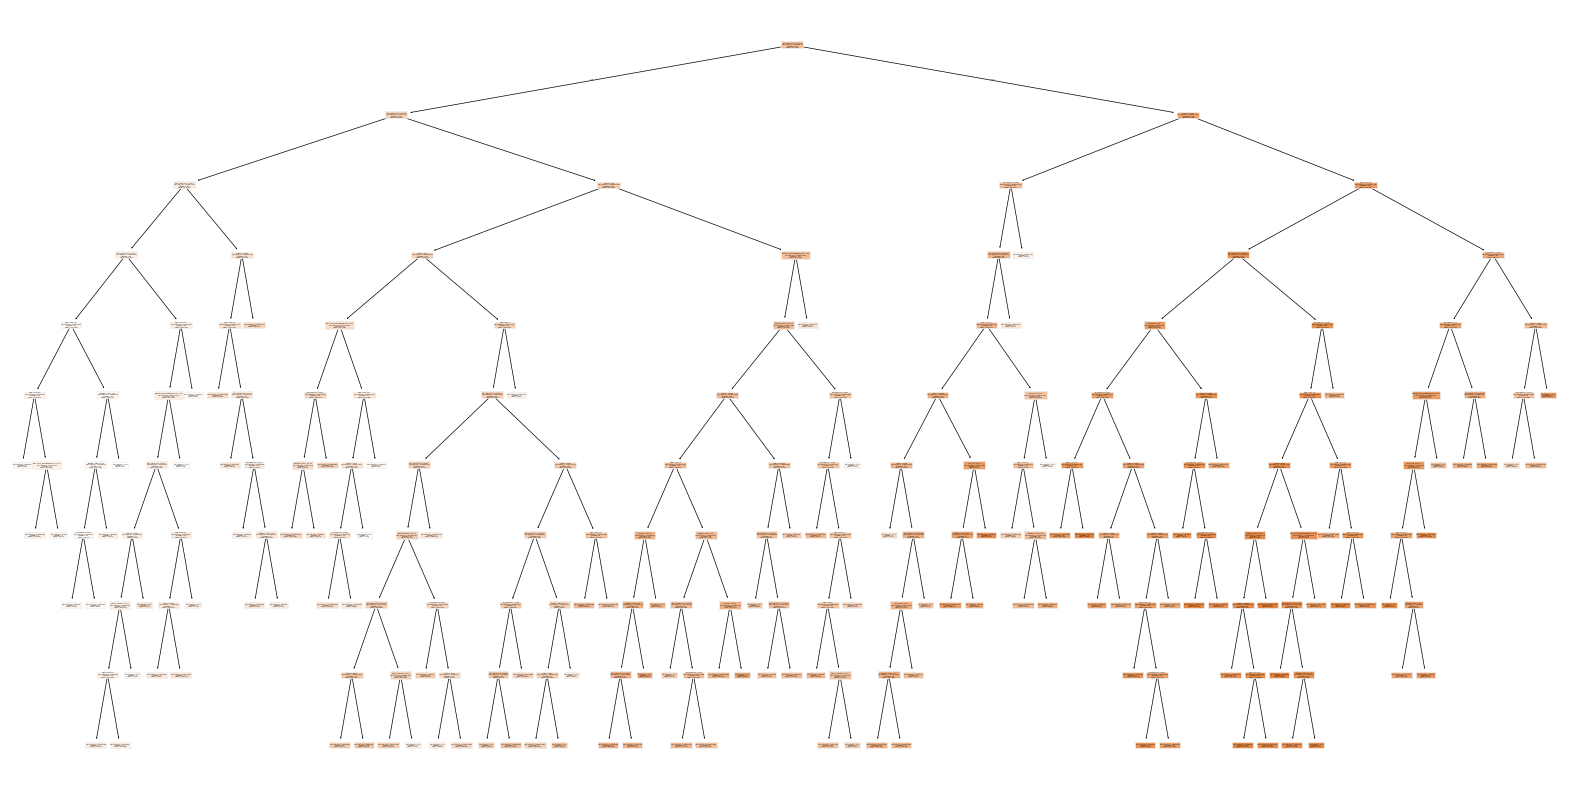

In [47]:
# Tree for CART
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Assuming dt_final is already trained
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
plot_tree(dt_final, filled=True, feature_names=train_x.columns)
plt.savefig("decision_tree.png", dpi=600)
plt.show()

In [46]:
print("R2 on the training data:")
print(dt_final.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(dt_final.score(X=test_x, y=test_y))

R2 on the training data:
0.9727089518051003
R2 on the testing data:
0.757715812742848


In [48]:
print("RMSE on the training data:")
print(mean_squared_error(train_y, dt_final.predict(train_x), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y, dt_final.predict(test_x), squared=False))

RMSE on the training data:
322.91814665797057
RMSE on the testing data:
922.8954973299212


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [49]:
print("Normalised RMSE on the training data:")
print(
    mean_squared_error(train_y, dt_final.predict(train_x), squared=False)
    / np.mean(train_y)
)
print("Normalised RMSE on the testing data:")
print(
    mean_squared_error(test_y, dt_final.predict(test_x), squared=False)
    / np.mean(test_y)
)

Normalised RMSE on the training data:
0.0722168443537336
Normalised RMSE on the testing data:
0.2005120261136868


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [50]:
# Interpreting the CART
# some attributes of the tree
print("Tree depth:{}".format(dt_final.get_depth()))
print("Number of leaves:{}".format(dt_final.get_n_leaves()))

Tree depth:10
Number of leaves:114


In [51]:
# Importance of the features
# the importances function returns a dataframe of two columns, Feature and Importance, and the features are ranked from the most important to the least.
imp = rfpimp.importances(dt_final, test_x, test_y)
print(imp)

                                                         Importance
Feature                                                            
days_since_2011                                              0.7431
temp                                                         0.4673
windspeed                                                    0.0590
hum                                                          0.0447
weathersit_RAIN/SNOW/STORM                                   0.0367
weathersit_MISTY                                             0.0225
weekday_SAT                                                  0.0093
mnth_JUN                                                     0.0074
weekday_WED                                                  0.0068
workingday_NO WORKING DAY                                    0.0016
mnth_APR                                                     0.0013
weekday_TUE                                                  0.0010
season_SUMMER                                   

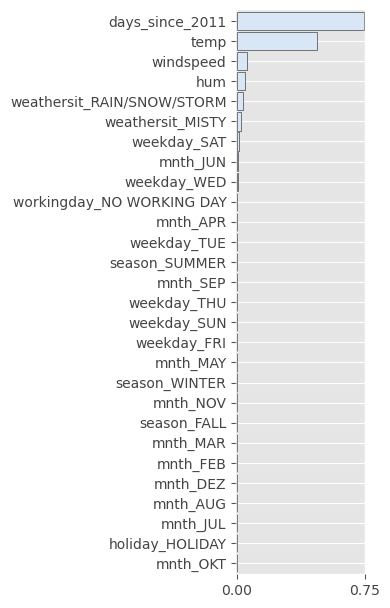

In [52]:
## Here is a barplot of the feature importance
viz = rfpimp.plot_importances(imp)
viz.view()

In [56]:
# Random Forest
# values of max_depth and min_samples_split
hyperparameters = {
    "max_depth": [10, 20, 30, 40, 50],
    "min_samples_split": [2, 4, 6, 8, 10],
}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print("The best parameter value is: ")
print(clf.best_params_)
print("The best score is: ")
print(clf.best_score_)

The best parameter value is: 
{'max_depth': 30, 'min_samples_split': 2}
The best score is: 
0.8594678489298346


In [55]:
rf_final = RandomForestRegressor(
    max_depth=clf.best_params_["max_depth"],
    min_samples_split=clf.best_params_["min_samples_split"],
    random_state=randomState_dt,
)
rf_final.fit(train_x, train_y)

RandomForestRegressor(max_depth=30, random_state=10000)

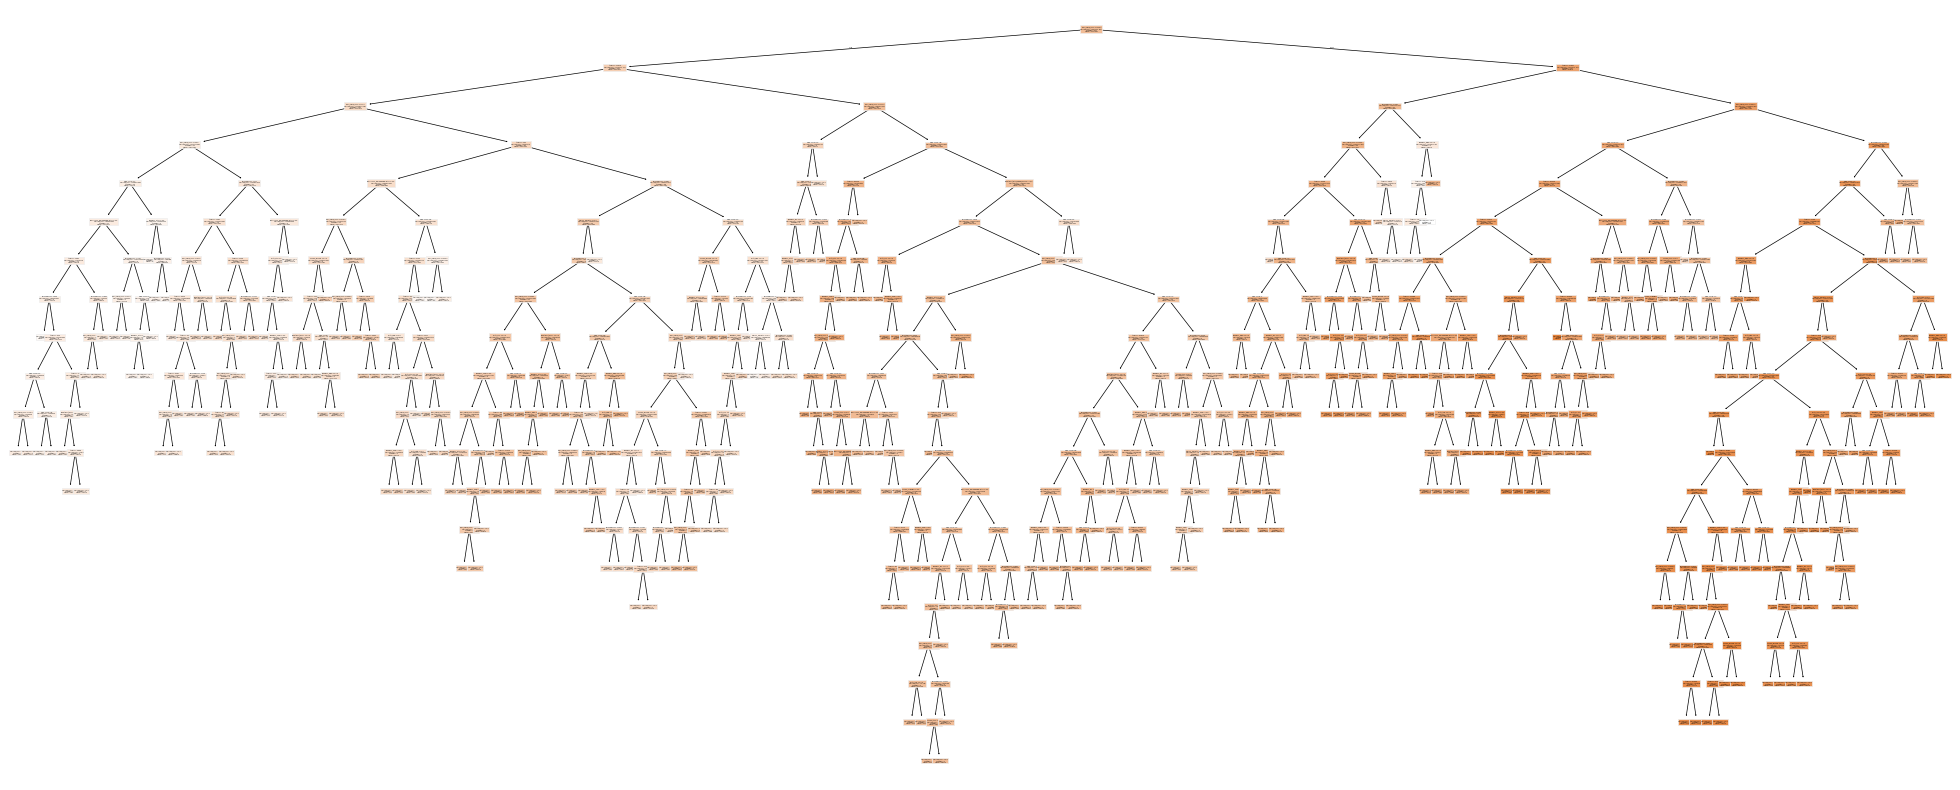

In [61]:
# Tree for Random Forest
single_tree = rf_final.estimators_[0]

plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plot_tree(single_tree, filled=True, feature_names=train_x.columns)
plt.savefig("random_forest_tree.png", dpi=600)  # Save the plot as an image file
plt.show()

In [62]:
print("R2 on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R2 on the training data:
0.9818090978256703
R2 on the testing data:
0.883608777650514


In [59]:
print("RMSE on the training data:")
print(mean_squared_error(train_y, rf_final.predict(train_x), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y, rf_final.predict(test_x), squared=False))

RMSE on the training data:
263.63888257826613
RMSE on the testing data:
639.6613442103948


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


                                                         Importance
Feature                                                            
days_since_2011                                              0.9539
temp                                                         0.4813
hum                                                          0.1041
windspeed                                                    0.0358
weathersit_MISTY                                             0.0063
workingday_NO WORKING DAY                                    0.0043
weathersit_RAIN/SNOW/STORM                                   0.0035
weekday_SUN                                                  0.0028
season_WINTER                                                0.0021
weekday_SAT                                                  0.0018
mnth_NOV                                                     0.0007
holiday_HOLIDAY                                              0.0007
season_SUMMER                                   

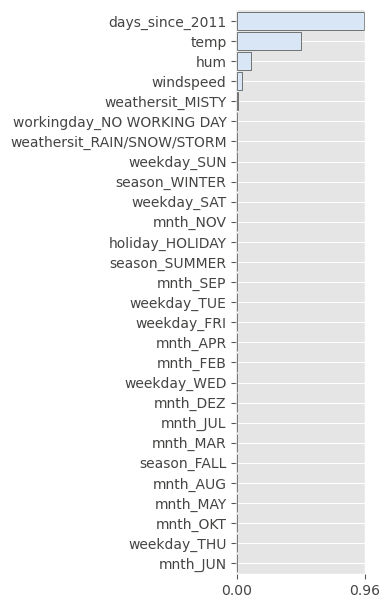

In [60]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

In [ ]:
# XGBOOST- only focus on tuning the max_depth and n_estimator
# values of max_depth and min_samples_split
hyperparameters = {
    "max_depth": [10, 20, 30, 40, 50],
    "n_estimators": [50, 100, 150, 200, 250],
}

randomState_xgb = 125
xgb = XGBRegressor(random_state=randomState_xgb)

# cv=5 by default, which means 5-fold cross-validation
gscv_xgb = GridSearchCV(xgb, hyperparameters)

gscv_xgb.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print("The best parameter value is: ")
print(gscv_xgb.best_params_)
print("The best score is: ")
print(gscv_xgb.best_score_)

In [ ]:
xgb_final = XGBRegressor(
    max_depth=gscv_xgb.best_params_["max_depth"],
    n_estimators=gscv_xgb.best_params_["n_estimators"],
    random_state=randomState_xgb,
)
xgb_final.fit(train_x, train_y)

In [ ]:
# Tree for xgboost
single_tree = xgboost.to_graphviz(xgb_final, num_trees=0, rankdir="LR")

plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
plt.savefig("xgb_tree.png", dpi=600)  # Save the plot as an image file
single_tree.view()

In [ ]:
print("R2 on the training data:")
print(xgb_final.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(xgb_final.score(X=test_x, y=test_y))

In [ ]:
print("RMSE on the training data:")
print(mean_squared_error(train_y, xgb_final.predict(train_x), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y, xgb_final.predict(test_x), squared=False))

In [ ]:
imp = rfpimp.importances(xgb_final, test_x, test_y)  # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

In [ ]:
# Comparing three models
# create a list of models
list_name_models = ["CART", "RF", "XGBoost"]
# use the models from above
list_reg_models = [dt_final, rf_final, xgb_final]

dict_models = dict()

for name, model in zip(list_name_models, list_reg_models):
    dict_models[name] = [
        model.score(train_x, train_y),
        model.score(test_x, test_y),
        model.score(train_x, train_y) - model.score(test_x, test_y),
    ]

# transform dict_models to dataframe
df_models = pd.DataFrame.from_dict(
    dict_models, orient="index", columns=["R2_train_data", "R2_test_data", "R2_diff"]
)
df_models
# you can then export df_models as a csv file and use it in MS Excel or Word
# df_models.to_csv(...)

The above result shows that the random forest model has a higher R2 on the testing data than CART and XGBoost, as well as a smaller R2 difference betwen training and testing data. 

This indicates that the random forest model is less subject to the overfitting issue and has a better generalisation.

The XGBoost also has a less extent of overfitting than CART. 

For this reason, it is uncommon to use CART to directly make predictions. Rather, CART is used to construct RF or GBDT.